# Obesity Risk Prediction

* We will implement logistic regression for multi-class classification.
* We will use One vs All and One vs One strategies.
* We will evaluate the model using appropriate metrics.

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

## Exploratory Data Analysis

* The data set being used for this lab is the "Obesity Risk Prediction" data set publically available on UCI Library.

* The data set has 17 attributes in total along with 2,111 samples.

In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


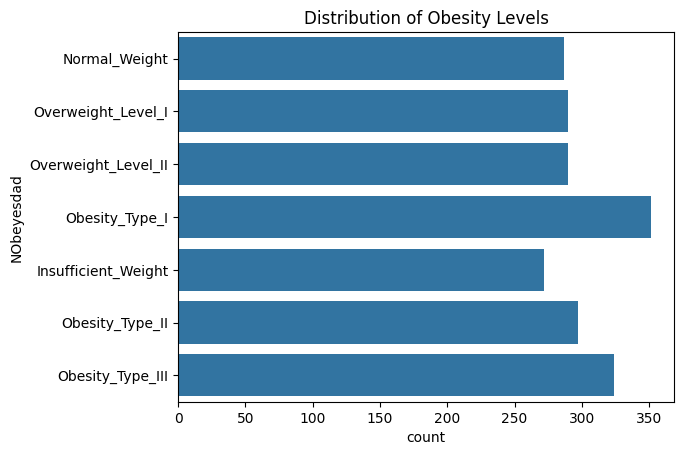

In [23]:
# Visualise the distribution of target variable to understand class balance

sns.countplot(y='NObeyesdad', data = data)
plt.title('Distribution of Obesity Levels')
plt.savefig('Distribution of Obesity Levels',dpi=300, bbox_inches='tight')
plt.show()

* The dataset is fairly balanced and hence wont be requiring any special attention in terms of biased training.

In [4]:
# Check for null values

print(data.isnull().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


* There are no null entries.

In [5]:
# Summarise the dataset

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

## Feature Scaling

In [6]:
# Feature Scaling

# Standardise the numerical features for better model performance.
continous_columns = data.select_dtypes(include=['float64']).columns.tolist()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continous_columns])

# Converting to a dataframe
scaled_df = pd.DataFrame(scaled_features, columns = scaler.get_feature_names_out(continous_columns))

# Combine with original dataset
scaled_data = pd.concat([data.drop(columns = continous_columns), scaled_df], axis =1)

In [7]:
scaled_data.head()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


## Onehot encoding

In [8]:
# Convert categorical variables into numerical format

# Identify the catergorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude the target variable

# Apply one hot encoding
encoder = OneHotEncoder( sparse_output= False, drop='first')
encoded_features = encoder.fit_transform( scaled_data[categorical_columns])

# Convert to a dataframe
encoded_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out(categorical_columns))

# Combine with original dataset
prepped_data = pd.concat([scaled_data.drop(columns = categorical_columns), encoded_df], axis = 1)

In [9]:
# Encode the targed variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Separate input and target data
X = prepped_data.drop('NObeyesdad', axis =1)
y = prepped_data['NObeyesdad']

## Model Training and Evaluation

In [12]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)


### Logistic Regression One vs All

In [13]:
# Training Logistic Regression model using One vs All

# Training
model_ova = LogisticRegression(multi_class= 'ovr', max_iter = 1000)
model_ova.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='ovr')

In [15]:
# Predictions
y_pred_ova = model_ova.predict(X_test)

# Evalutation
print('One Vs All strategy')
print(f"Accuracy : {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One Vs All strategy
Accuracy : 76.12%


### Logistic Regression One vs One

In [16]:
# Training Logistic Regression model using One vs One approach

# Training
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter = 1000))
model_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

In [17]:
# Predictions
y_pred_ovo = model_ovo.predict(X_test)

# Evaluation
print('One vs One strategy')
print(f"Accuracy : {np.round(100*accuracy_score(y_test, y_pred_ovo),2)}%")

One vs One strategy
Accuracy : 92.2%


## Feature Importance

### One vs All Approach

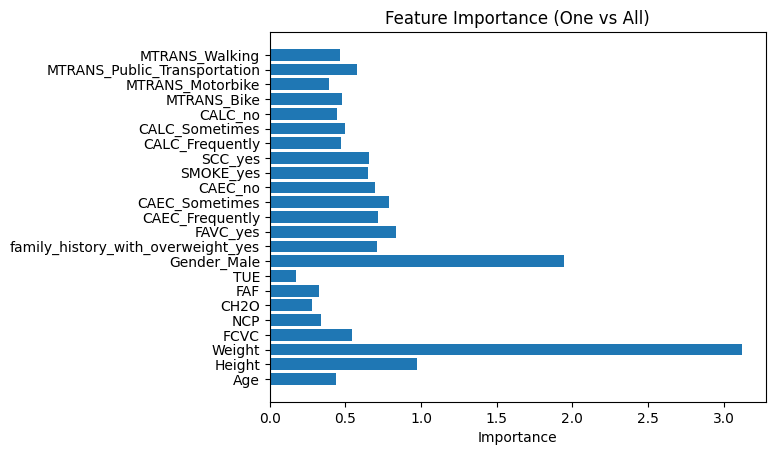

In [21]:
# One vs All model

# Feature Importance Plot
feature_importance = np.mean(np.abs(model_ova.coef_), axis = 0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance (One vs All)")
plt.xlabel('Importance')
plt.savefig('Feature Importance (One vs All)',dpi=300, bbox_inches='tight')
plt.show()

### One vs One Approach

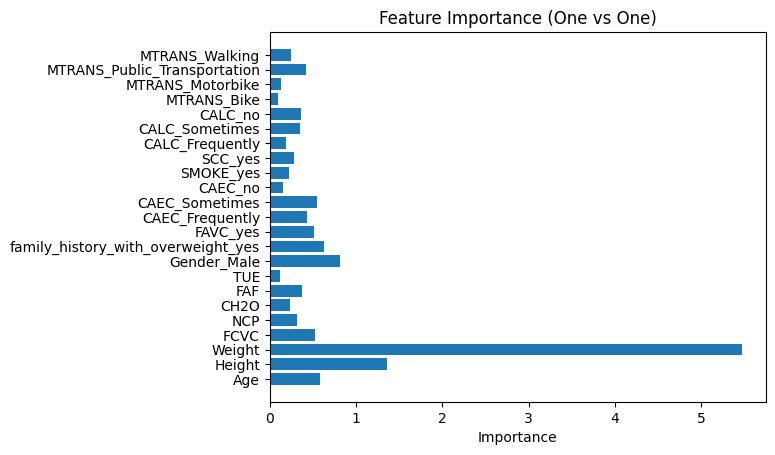

In [22]:
# One vs One Approach

# Collect all coefficients from each underlying binary classifier
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])

# Now take the mean accross all the classifiers
feature_importance = np.mean(np.abs(coefs), axis = 0)

# Feature Importance Plot
plt.barh(X.columns, feature_importance)
plt.title('Feature Importance (One vs One)')
plt.xlabel('Importance')
plt.savefig('Feature Importance (One vs One)',dpi=300, bbox_inches='tight')
plt.show()